## Задание

Разобранными на лекции методами список того, что можно применять к метрикам-отношениям, не ограничивается. Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида  𝑥/𝑦  (у нас clicks/likes).

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR)

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
- Посчитаем в обеих группах поюзерную метрику 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
- После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

Задача

1. Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
2. Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [1]:
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
%matplotlib inline
rc = {
    'figure.figsize': (10, 6)
}
sns.set(rc=rc, style='whitegrid')

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}

In [4]:
# Загружаем нужные данные
query = """
    select
      user_id,
      exp_group,
      sum(action = 'view') views,
      sum(action = 'like') likes,
      likes / views CTR
    from
      simulator_20220720.feed_actions
    where
      exp_group in (0, 1, 2, 3)
      and toDate(time) between '2022-06-13'
      and '2022-06-19'
    group by
      exp_group,
      user_id
"""
df = ph.read_clickhouse(query=query, connection=connection)

In [5]:
df

,user_id,exp_group,views,likes,CTR
0,115383,3,30,9,0.300000
1,18392,1,32,7,0.218750
2,131473,2,134,14,0.104478
3,123580,3,48,13,0.270833
4,32420,2,128,26,0.203125
...,...,...,...,...,...
40074,27030,0,39,8,0.205128
40075,122758,3,198,30,0.151515
40076,132567,1,296,45,0.152027
40077,122190,3,65,19,0.292308


### Исследование 0 и 3 групп

In [6]:
df_03 = df[df.exp_group.isin([0, 3])]

In [7]:
CTRcontrol = df_03[df_03.exp_group == 0].likes.sum() / df_03[df_03.exp_group == 0].views.sum()

In [8]:
CTRcontrol

0.20823612262916305

In [9]:
df_03['linearized_likes'] = df_03.likes - df_03.views * CTRcontrol

C:\Users\Egor\AppData\Local\Temp\ipykernel_7412\1572176548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03['linearized_likes'] = df_03.likes - df_03.views * CTRcontrol


In [10]:
df_03

,user_id,exp_group,views,likes,CTR,linearized_likes
0,115383,3,30,9,0.300000,2.752916
3,123580,3,48,13,0.270833,3.004666
6,30319,0,110,21,0.190909,-1.905973
8,118359,3,38,7,0.184211,-0.912973
10,7626,0,39,14,0.358974,5.878791
...,...,...,...,...,...,...
40064,110492,0,17,4,0.235294,0.459986
40073,136299,0,116,35,0.301724,10.844610
40074,27030,0,39,8,0.205128,-0.121209
40075,122758,3,198,30,0.151515,-11.230752


<AxesSubplot:xlabel='CTR', ylabel='Count'>

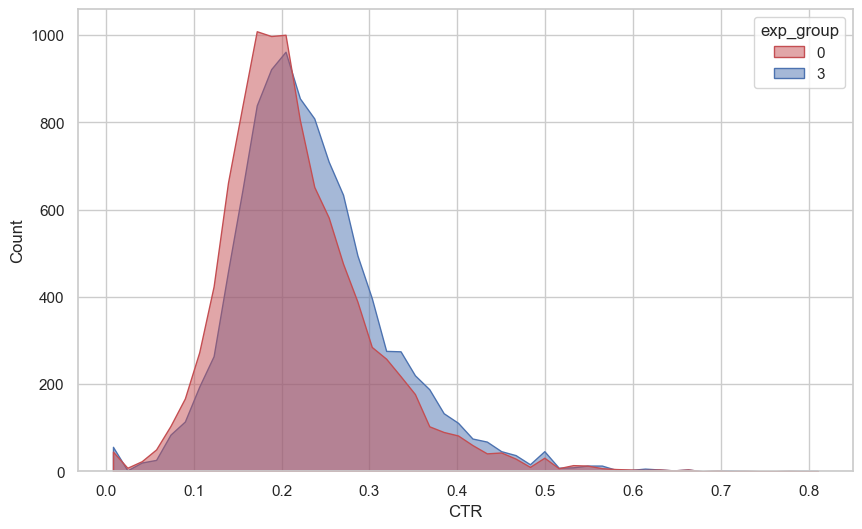

In [11]:
sns.histplot(data = df_03, 
             x='CTR', 
             hue='exp_group', 
             palette = ['r', 'b'],
             alpha=0.5,
             kde=False,
             element="poly",
             bins=50)

In [12]:
stats.ttest_ind(df_03[df_03.exp_group == 0].CTR,
                df_03[df_03.exp_group == 3].CTR,
                equal_var=False).pvalue

1.055849414662529e-43

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

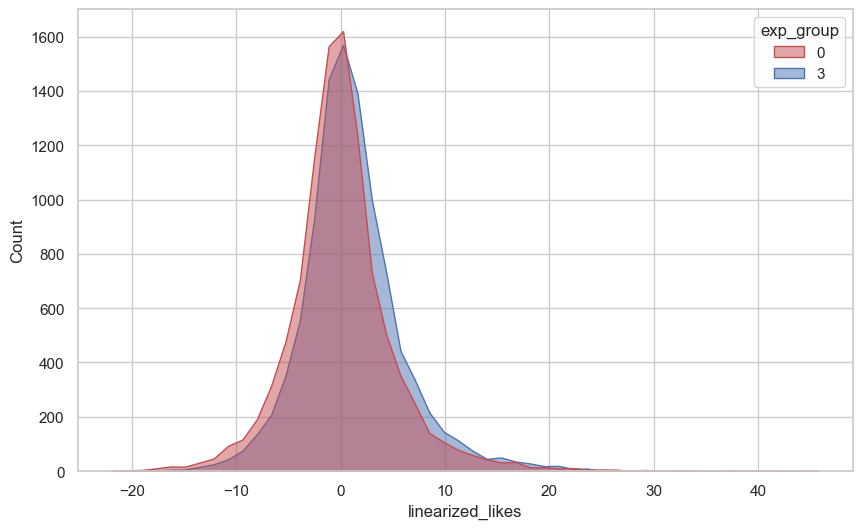

In [13]:
sns.histplot(data = df_03, 
             x='linearized_likes', 
             hue='exp_group', 
             palette = ['r', 'b'],
             alpha=0.5,
             kde=False,
             element="poly",
             bins=50)

In [14]:
stats.ttest_ind(df_03[df_03.exp_group == 0].linearized_likes,
                df_03[df_03.exp_group == 3].linearized_likes,
                equal_var=False).pvalue

5.4914249479690016e-52

**Вывод:**

Тест на обеих метриках показал, что средние отличаются. И хоть на метрике linearized_likes p-value меньше, особой роли это не играет. На графиках так же заметно, что расперделение тестовой группы немного смещается вправо

### Исследование 1 и 2 групп

In [15]:
df_12 = df[df.exp_group.isin([1, 2])]

In [16]:
CTRcontrol = df_12[df_12.exp_group == 1].likes.sum() / df_12[df_12.exp_group == 1].views.sum()

In [17]:
CTRcontrol

0.20802680490126244

In [18]:
df_12['linearized_likes'] = df_12.likes - df_12.views * CTRcontrol

C:\Users\Egor\AppData\Local\Temp\ipykernel_7412\1195599845.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_12['linearized_likes'] = df_12.likes - df_12.views * CTRcontrol


In [19]:
df_12

,user_id,exp_group,views,likes,CTR,linearized_likes
1,18392,1,32,7,0.218750,0.343142
2,131473,2,134,14,0.104478,-13.875592
4,32420,2,128,26,0.203125,-0.627431
5,24239,2,90,40,0.444444,21.277588
7,27443,1,29,2,0.068966,-4.032777
...,...,...,...,...,...,...
40070,21697,1,22,2,0.090909,-2.576590
40071,1232,2,96,5,0.052083,-14.970573
40072,120653,1,74,15,0.202703,-0.393984
40076,132567,1,296,45,0.152027,-16.575934


<AxesSubplot:xlabel='CTR', ylabel='Count'>

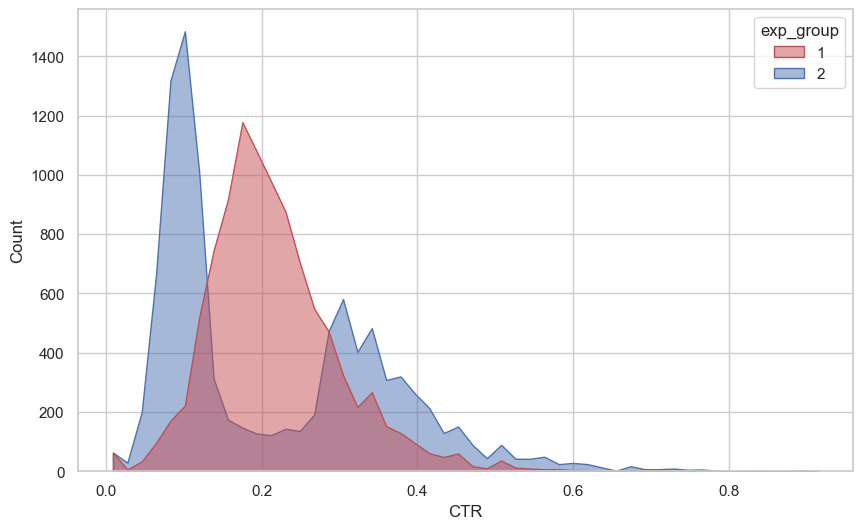

In [20]:
sns.histplot(data = df_12, 
             x='CTR', 
             hue='exp_group', 
             palette = ['r', 'b'],
             alpha=0.5,
             kde=False,
             element="poly",
             bins=50)

In [21]:
stats.ttest_ind(df_12[df_12.exp_group == 1].CTR,
                df_12[df_12.exp_group == 2].CTR,
                equal_var=False).pvalue

0.4780623130874935

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

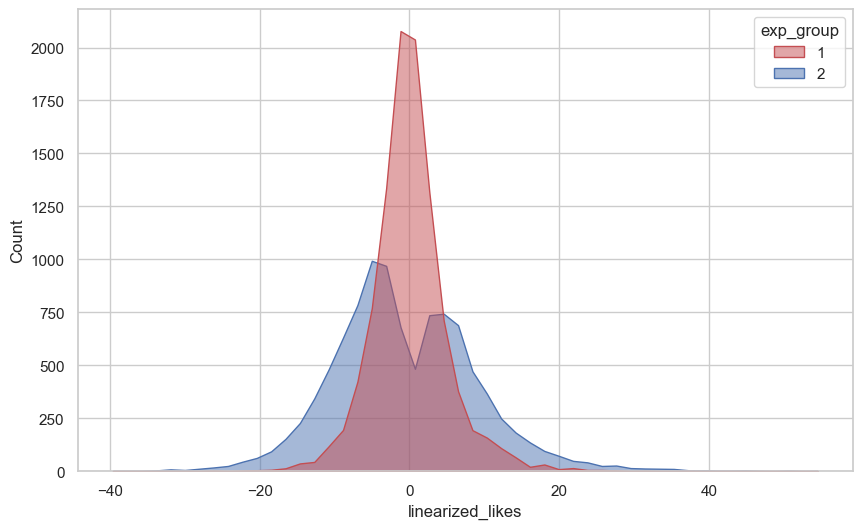

In [22]:
sns.histplot(data = df_12, 
             x='linearized_likes', 
             hue='exp_group', 
             palette = ['r', 'b'],
             alpha=0.5,
             kde=False,
             element="poly",
             bins=50)

In [23]:
stats.ttest_ind(df_12[df_12.exp_group == 1].linearized_likes,
                df_12[df_12.exp_group == 2].linearized_likes,
                equal_var=False).pvalue

9.439432187037815e-10

**Вывод:**

До этого мы уже заметили, что хоть t-test не выявил отличие между средними двух групп, на деле же распределения CTR-ов сильно отличаются. Одкако при иследовании linearized_likes t-test выдаёт низкое p-value, что в этот раз позволяет отклонить гипотезу о равенстве средних. На графике видно, что распределения linearized_likes сильно похожи на CTR-ы, но значения как будто более "прижаты" к средним распределений